# TP2 TVID : Compensation de mouvement et Compression Video

# Matis Braun

On fait les importations et on récupère les images qui nous utiliserons durant ce tp. On tranforme notre image en représentation matricielle, et on normalise les valeurs des couleurs entre 0 et 1

Ici, j'ai utilisé un screen d'une scène de l'anime Jujutsu Kaisen que j'ai animé. Etant donné que l'image fait 2664 × 1540, le traitement prend du temps. Donc si jamais vous voulez lancer sans perdre de temps, utiliser les autres images


(décommentez #IMG1 = Image.open("/kaggle/input/firstimage/1.png") et #IMG2 = Image.open("/kaggle/input/firstimage/2.png"))

2664
1540


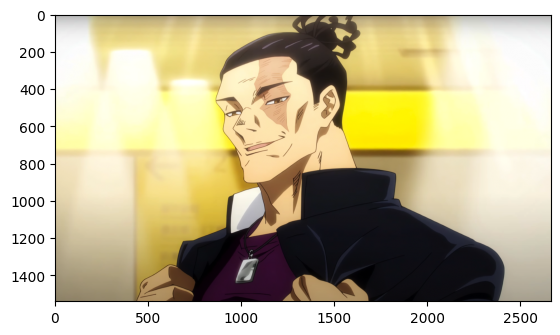

2660
1540


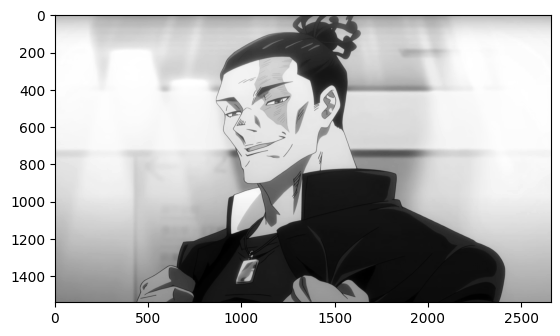

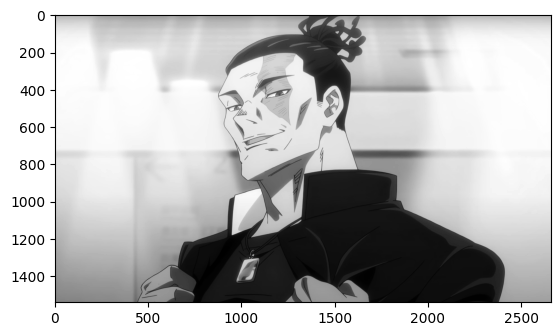

In [4]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
from IPython.display import HTML


IMG1 = Image.open("/kaggle/input/todotpcv/Todo1.png")
IMG2 = Image.open("/kaggle/input/todotpcv/Todo2.png")

#IMG1 = Image.open("/kaggle/input/firstimage/1.png")
#IMG2 = Image.open("/kaggle/input/firstimage/2.png")

img1 = np.asarray(IMG1) / 255
img2 = np.asarray(IMG2) / 255

print(len(img1[0]))
print(len(img1))

imgplot = plt.imshow(img1)
plt.show()

img1_g = np.dot(img1[..., :3], [0.2989, 0.5870, 0.1140])
img2_g = np.dot(img2[..., :3], [0.2989, 0.5870, 0.1140])

height, width = img1_g.shape

img1_g = img1_g[:height, :width - 4]
img2_g = img2_g[:height, :width - 4]

print(len(img1_g[0]))
print(len(img1_g))

imgplot = plt.imshow(img1_g, cmap= 'gray')
plt.show()
imgplot = plt.imshow(img2_g, cmap= 'gray')
plt.show()

In [5]:
fig, ax = plt.subplots(figsize=(12, 12))
def update_plot(frame):
    ax.clear()
    img = img1_g if frame % 2 == 0 else img2_g
    ax.imshow(img, cmap='gray', interpolation='nearest')
    ax.set_title('Comparaison des 2 images')
    ax.set_aspect('equal', adjustable='box')

ani = animation.FuncAnimation(fig, update_plot, frames=range(10), interval=1000)
video = ani.to_html5_video()
plt.close(fig)
HTML(video)

Comme on peut le voir, la plupart des traits du personnage bougent, il n'est pas énormément statique, ce qui peut être intéressant à analyser. Vu que l'image à juste été screen sur une video venant de youtube, sa qualité n'est pas incroyable (colorbanding,... car il n'a pas été tiré de sa source la plus "pure" (Blu-Ray)) ce qui fait que les couleurs de la veste par exemple qui devait être de la même intensité ne l'est pas, il y a des donc des imperfections. Ce qui fait que nos vecteurs de mouvement ne seront pas uniquement focalisé sur les traits et les traits d'ombres du personnage (donc il y aura des flèches un peu partout). Mais nous verrons cela dans un exemple plus tard.

# QUESTION 1

On va faire une estimation de mouvement backward.


J'ai donc fait la fonction estimation_mouvement qui va faire l'estimation en backward du mouvement entre l'image I1 et l'image I2.
On stock dans un premier temps les coordonées de chaque blocs sur lesquels nous allons itérer. On va créer ensuite notre tableau qui va stocker les vecteurs de déplacement des blocs que l'on aura calculés dans notre algorithme. Le tableau est donc de taille (n bloc en y, n bloc en x), donc pour notre image (266, 154).


On itère de bloc en bloc sur l'image 2, et on regarde les différents blocs autour de chaque bloc itéré dans un "rayon" de search_range. Si le bloc ne dépasse pas de l'image, on va regarder la "SAD" (Sum of Absolute Differences) entre le bloc à search_range de distance de l'image 1 et le bloc central de l'image 2.
Si jamais l'erreur est la plus petite des blocs au alentour à search_range de distance du bloc central en I2, on garde le bloc avec la plus petite erreur.
Lorsque l'on aura vu tout les blocs de l'image 1 autour de notre bloc de base, on garde les coordonées du bloc avec la plus petite erreur et on sauvegarde son vecteur.

On fait ça pour tout les blocs de l'image 2, ce qui résultera en un tableau de vecteur (image 2 à image 1) pour chaque bloc de l'image 2 sur son bloc le plus "ressemblant" de l'image 1.

In [10]:
def estimation_mouvement(I1, I2, block_size, search_range):
    height, width = I2.shape
    #prend les coords chaque bloc
    coords_blocs = []
    for y in range(0, height - block_size + 1, block_size):
        for x in range(0, width - block_size + 1, block_size):
            coords_blocs.append((y, x))
    #init vect_mouvement
    vecteur_mouvement = np.zeros((height // block_size, width // block_size, 2), dtype=int)
    #on va dans chaque bloc
    for y, x in coords_blocs:
        #save bloc moins d'erreur
        meilleur_vect, erreur = (0, 0), float('inf')
        blocI2 = I2[y:y + block_size, x:x + block_size]
        #on a les distances qui changent
        for y2 in range(- search_range, search_range + 1):
            for x2 in range(- search_range, search_range + 1):
                #les coords des blocs alentours
                y_res, x_res = y + y2, x + x2
                #si depasse pas img
                if 0 <= y_res < height - block_size and 0 <= x_res < width - block_size:
                    #formule d'ereur cours
                    blocI1 = I1[y_res:y_res + block_size, x_res:x_res + block_size]
                    erreur_d = np.sum(np.abs(blocI2 - blocI1))
                    if erreur_d < erreur:
                        meilleur_vect = (y2, x2)
                        erreur = erreur_d
            vecteur_mouvement[y // block_size, x // block_size] = meilleur_vect
    return vecteur_mouvement

In [11]:
block_size = 10
search_range = 50
vecteur_mouvement = estimation_mouvement(img1_g, img2_g, block_size, search_range)

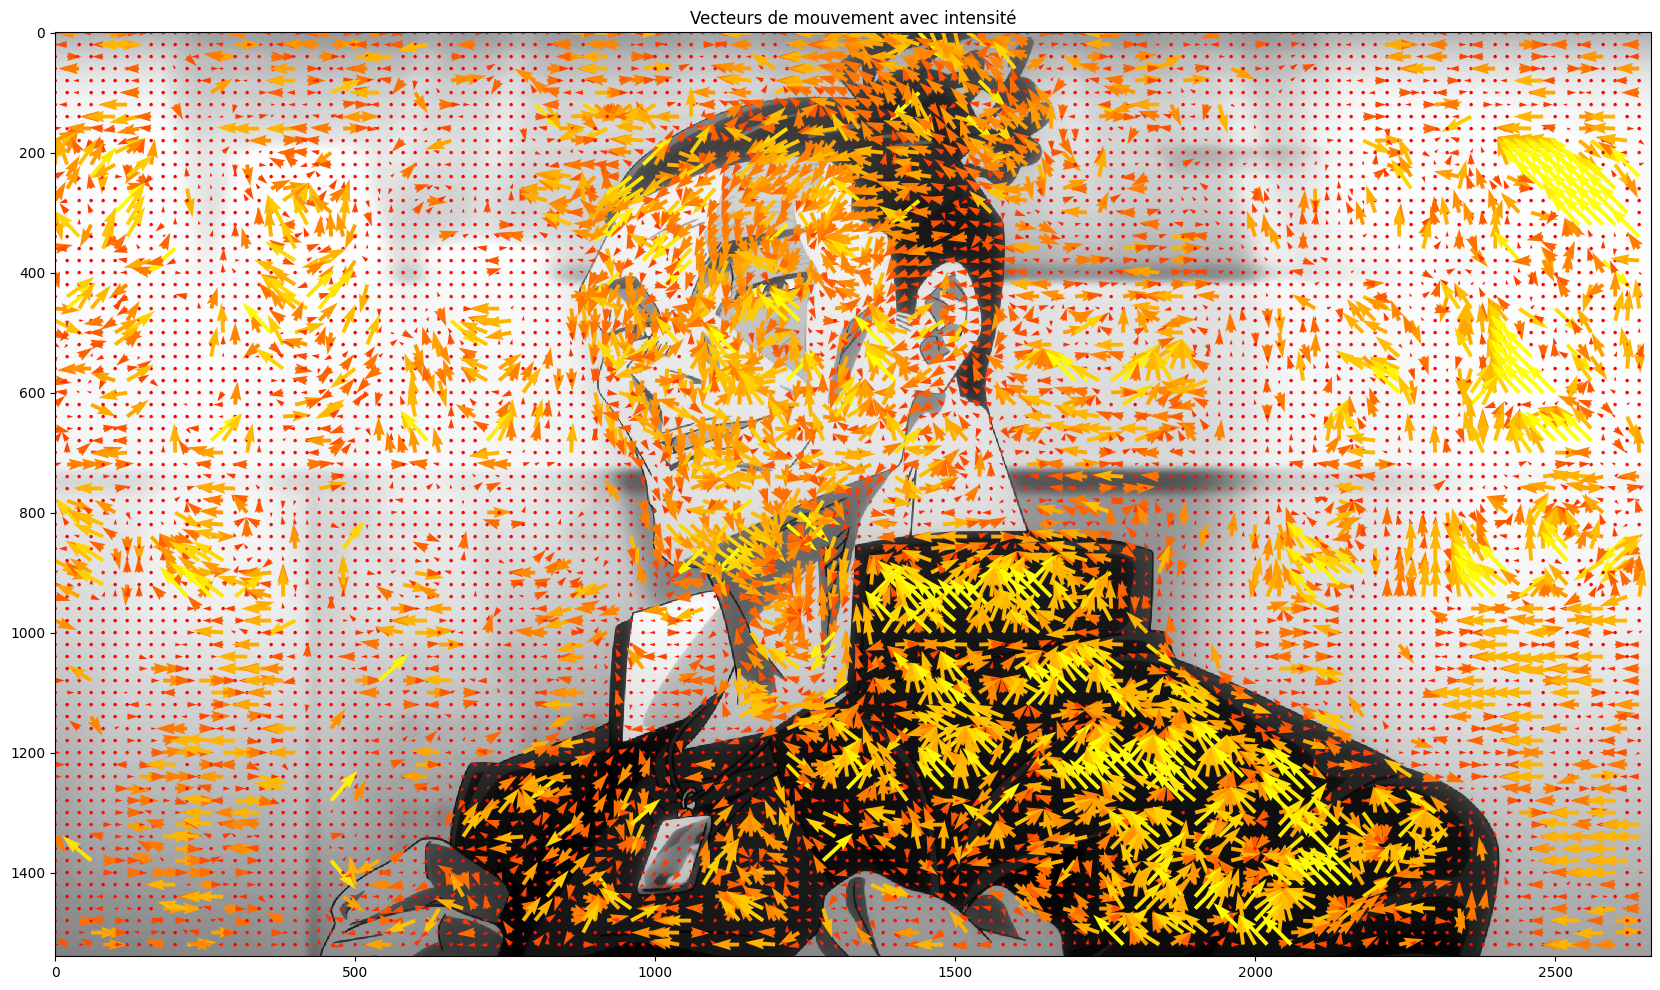

In [12]:
div_fleches = 2
div_vecteurs = vecteur_mouvement[::div_fleches, ::div_fleches]
div_height, div_width, _ = div_vecteurs.shape
Y, X = np.mgrid[0:div_height, 0:div_width] * block_size * div_fleches
U = div_vecteurs[:, :, 0]
V = div_vecteurs[:, :, 1]
intensite_distance = np.sqrt(U**2 + V**2)

plt.figure(figsize=(30, 12))
plt.imshow(img2_g, cmap='gray', interpolation='nearest')
quiver = plt.quiver(X, Y, V, U, intensite_distance, angles='xy', scale_units='xy', scale=1, cmap='autumn')

plt.title('Vecteurs de mouvement avec intensité')
plt.show()

Si on regarde la machoire, les cheveux, la bouche,... on constate que nos vecteurs de mouvement montrent bien la bonne direction du mouvement de l'image 2 à l'image 1

# QUESTION 2 : 

# Sachant que l’on va vouloir reconstruire la frame F2 a partir de F1, pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que se serait-il passe sinon ? (pensez a quels artefacts visuels on aurait obtenu)

Avant de répondre à la question, récapitulons ce qu'est de la Motion Estimation Forward et Backward.

- Pour la ME forward, la méthode que l'on utilise est que l'on va prendre les blocs dans l'image 1 et essayer de trouver le bloc qui correspond le mieux dans l'image 2. On va récupérer le vecteur du mouvement de chaque bloc de l'image 1 vers l'image 2.

- Pour la ME backward, c'est l'inverse, on va prendre les blocs dans l'image 2 et essayer de trouver le bloc qui correspond le mieux dans l'image 1. On va récupérer le vecteur du mouvement de chaqsue bloc dans l'image 2 vers l'image 1.

Donc maintenant quel est l'avantage du backward ?

Vu que pour le backward, on itère de bloc en bloc à partir de l'image 2, on est sûr que tout les pixels de l'image 2 auront une valeur. Car si l'on veut reconstruire l'image 2 en faisant du forward, donc en itèrant à partir de l'image 1, il peut arriver que des zones de l'image 2 n'aient pas de ressemblance directe avec l'image 1, et que donc on ait des sortes d'artefact visuel comme des vides/trous dans la reconstitution de l'image 2 sans valeur de pixel, car notre algorithme aura décidé que cette partie de l'image 2 n'avait aucune ressemblance avec la 1. Il y a donc des endroits de l'image 2 qui n'auraient jamais été choisis comme ressemblant à celle de l'image 1. Alors qu'à l'inverse, en backward, on est sur que tout les blocs de l'image 2 ont une correspondance dans l'image 1. 

On peut aussi avoir une sorte de superposition en forward. Par exemple, si pour deux blocs de l'image 1 à la suite, on trouve à peu près au même endroit dans l'image 2 le bloc ressemblant, on va avoir une superposition de blocs.

# QUESTION 3

On va donc reconstruire notre image I2 avec les vecteurs de déplacements que nous avons calculé et l'image I1.

On va donc itérer bloc par bloc et récupérer à chaque fois les informations importantes :
- x2 et y2 : le numéro du bloc dans l'image de "normalement" l'image 2 (ex : 3ème en x et 6ème en y)
- dx et dy : le vecteur déplacement du x2 y2 bloc de l'image I2 vers le bloc correspondant de l'image I1
- x et y : les coordonnées du bloc dans l'image I2 (haut à gauche du bloc)
- x_ref et y_ref : les coordonnées du bloc correspondant en I1 (coordonnées du bloc I2 + vecteurs déplacement du bloc I2 vers I1)

Après avoir récupéré ces informations, on regarde juste si le bloc correspondant en I1 ne dépasse pas de l'image, et si il ne dépasse pas, on mets le bloc aux coordonnées x_res,y_res de l'image I1 aux coordonnées x,y de l'image I2 (on prend les coordonnées du bloc qu'on veut remplir dans I2, on va dans I1 et on prend ces coordonnées + vecteur de mouvements, on prend le bloc dans I1 dans cette position calculé et on ajoute ce bloc aux coordonnées du bloc qu'on veut remplir dans I2)

In [13]:
def reconstruction_image(I1, vecteurs_mouvement, block_size):
    height, width = I1.shape    
    I2_reconstruit = np.zeros((height, width))
    #deplace block en block de i2
    for y2 in range(vecteurs_mouvement.shape[0]):
        for x2 in range(vecteurs_mouvement.shape[1]):
            #vect i2 vers i1
            dy, dx = vecteurs_mouvement[y2, x2]
            #coord i2
            x, y = x2 * block_size, y2 * block_size
            #coord i1
            x_res, y_res = x + dx, y + dy
            if 0 <= y_res < height - block_size and 0 <= x_res < width - block_size:
                I2_reconstruit[y:y + block_size, x:x + block_size] = I1[y_res:y_res + block_size, x_res:x_res + block_size]
    return I2_reconstruit

In [14]:
def calcul_mse(I1, I2):
    mse = np.mean((I1 - I2) ** 2)
    return mse

In [16]:
I2_reconstruit = reconstruction_image(img1_g, vecteur_mouvement, block_size)

mse = calcul_mse(img2_g, I2_reconstruit)
print(f"MSE de reconstruction: {mse}")

erreur = img2_g - I2_reconstruit

MSE de reconstruction: 0.0001210805517497005


On constate qu'on a une faible MSE ce qui veut dire que notre algorithme d'estimation de mouvement backward est plutot bon

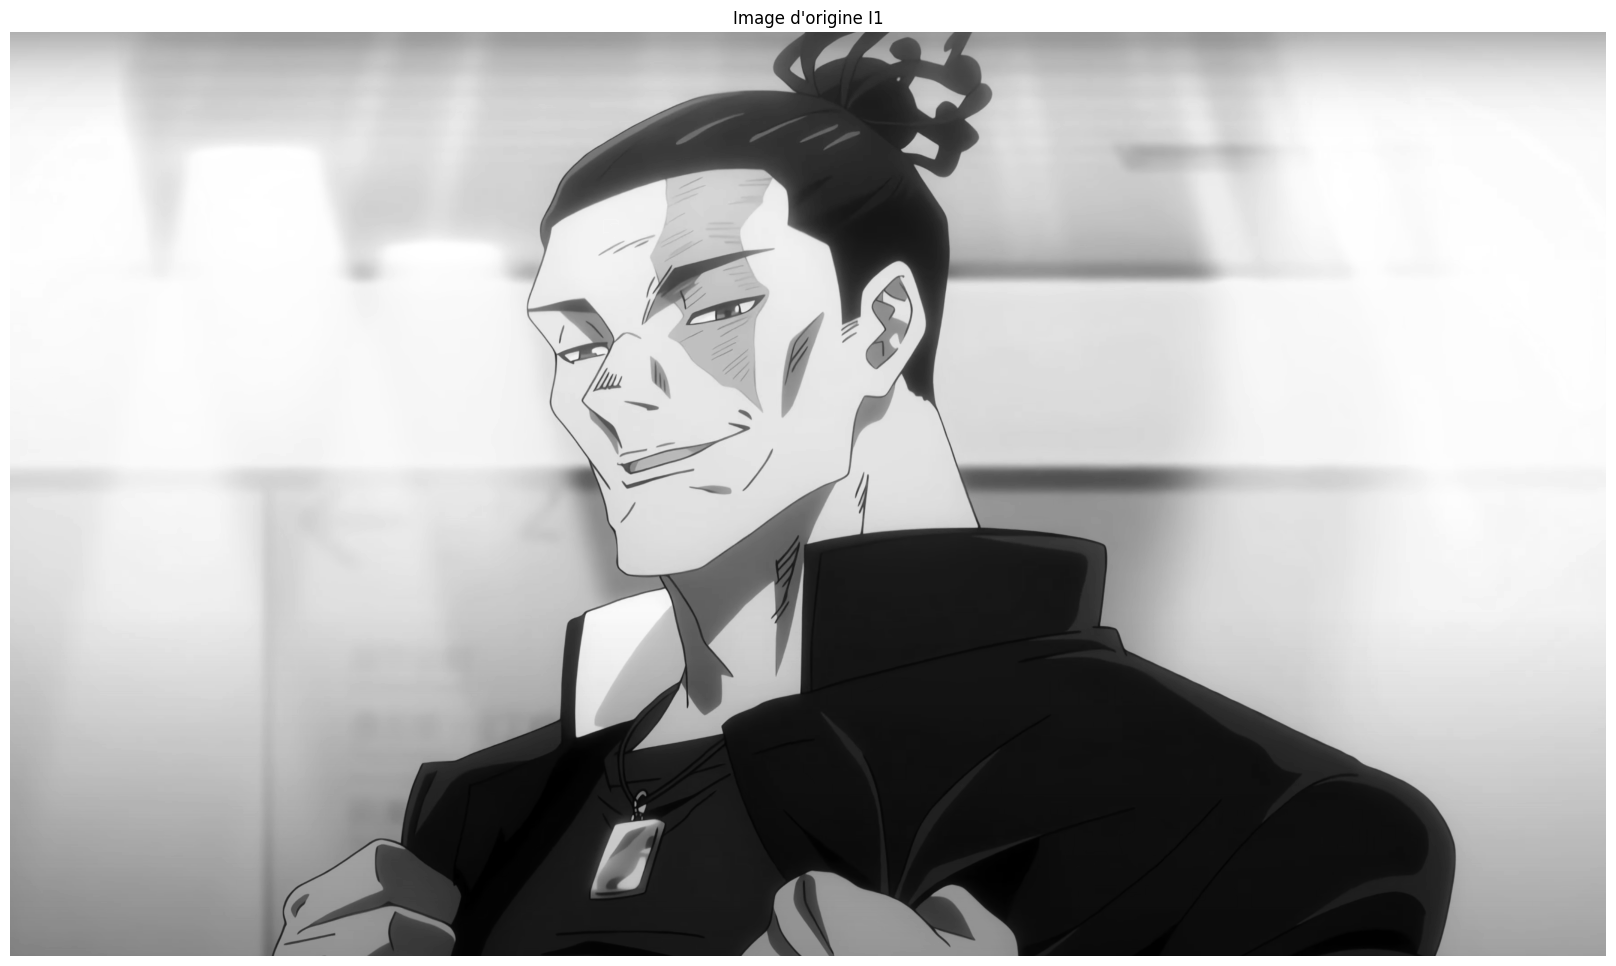

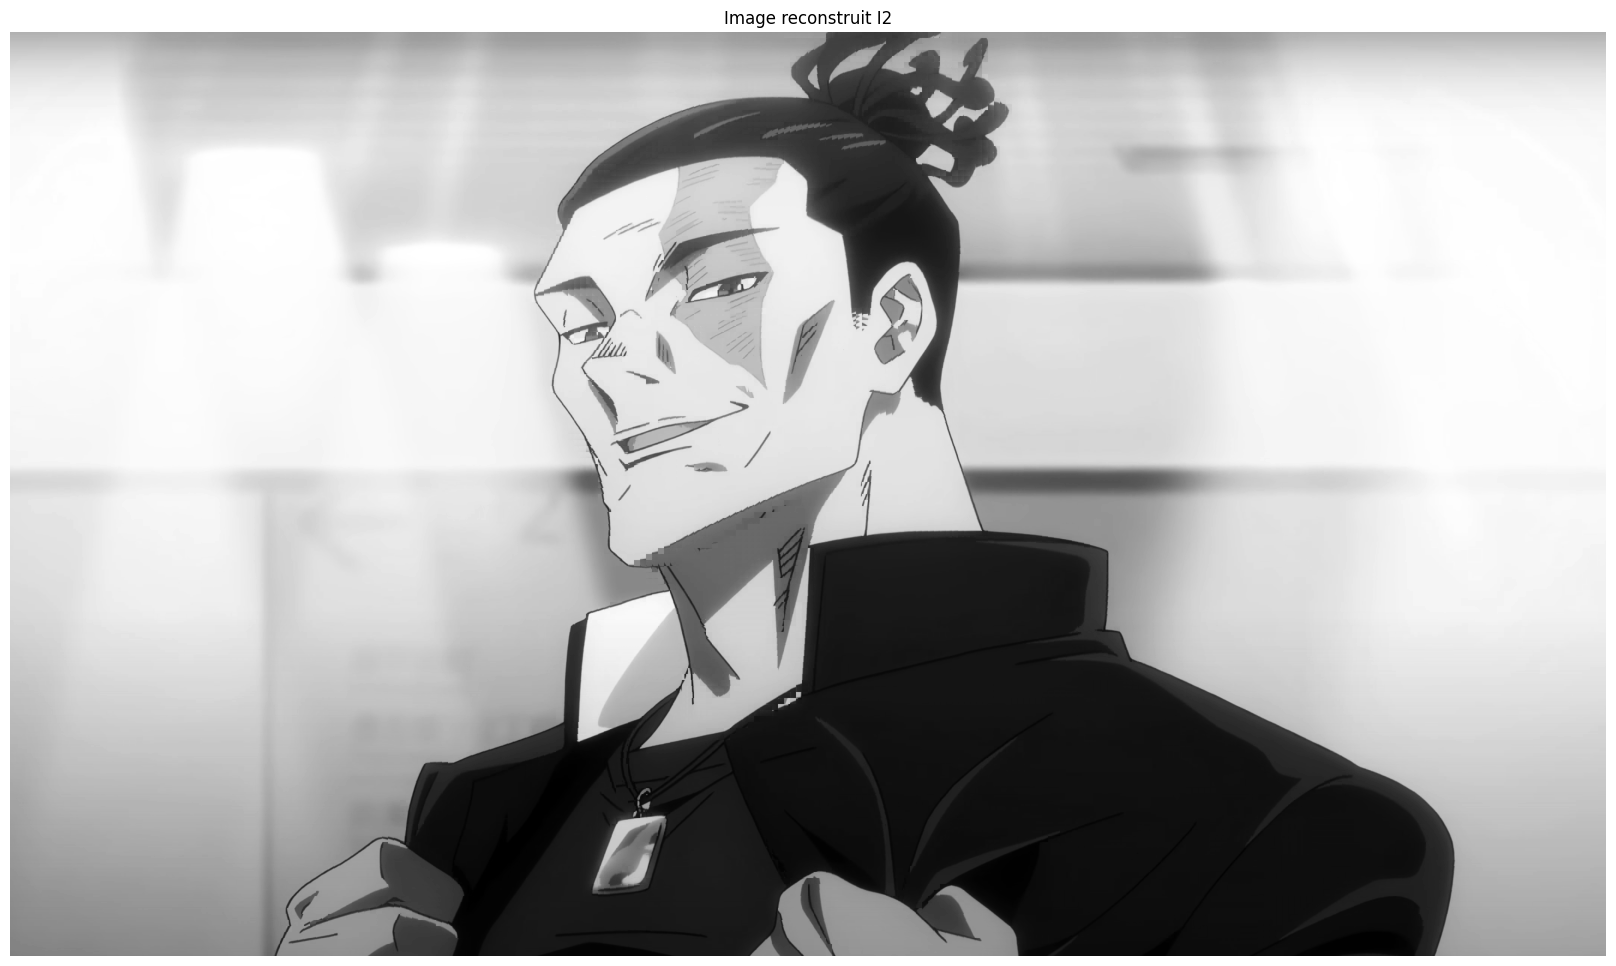

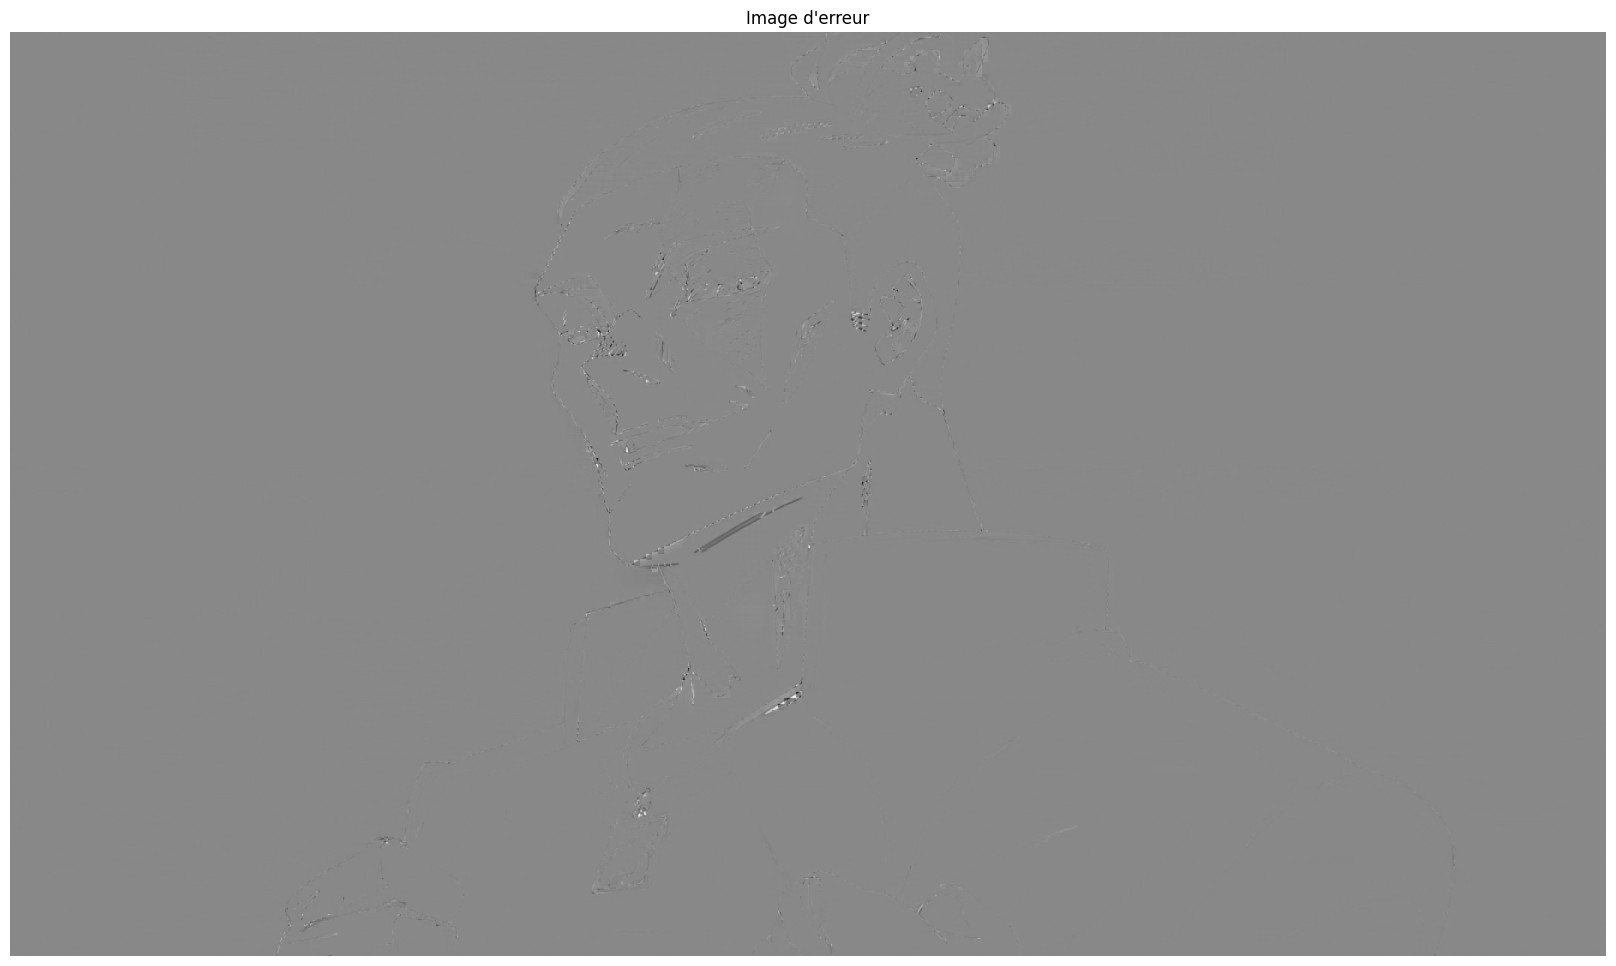

In [18]:
plt.figure(figsize=(30, 12))

plt.title("Image d'origine I1")
plt.imshow(img1_g, cmap= 'gray')
plt.axis('off')

plt.show()

plt.figure(figsize=(30, 12))

plt.title("Image reconstruit I2")
plt.imshow(I2_reconstruit, cmap='gray')
plt.axis('off')

plt.show()

plt.figure(figsize=(30, 12))

plt.title("Image d'erreur")
plt.imshow(erreur, cmap='gray')
plt.axis('off')

plt.show()

In [19]:
fig3, ax3 = plt.subplots(figsize=(12, 12))
def update_plot3(frame):
    ax3.clear()
    img = img1_g if frame % 2 == 0 else I2_reconstruit
    ax3.imshow(img, cmap='gray', interpolation='nearest')
    ax3.set_title('Mouvement entre image 1 et image 2 reconstruit')
    ax3.set_aspect('equal', adjustable='box')

ani3 = animation.FuncAnimation(fig3, update_plot3, frames=range(10), interval=1000)
video3 = ani3.to_html5_video()
plt.close(fig3)
HTML(video3)

On constate dans notre reconstruction que la plupart des mouvements ont été bien reconstruit. Par exemple la veste qui bouge sur tout les traits entre les 2 images, a bien été reconstruit. Pareil pour les mains, le tshirt, la tete, le collier, même les cheveux entre mêlée ont bien été reconstruit,... Seul certains endroits, comme le menton, le fil du collier,... ont eu de grosses erreurs

# QUESTION 4

# Supposant que l’on n’aura plus acces a F2, quelles sont les 3 donnees ”classiques” (en plus du parametres de taille de bloc) dont on a besoin pour la reconstruire de facon parfaite en compensation de mouvement ?

Pour reconstruire parfaitement l'image 2, il nous faudra donc :
- L'image de référence (l'image 1)
- Les vecteurs de mouvement de I2 vers I1 que on aura calculé
- Notre image d'erreur

Avec ces 3 données, ce que l'on va faire c'est tout d'abord la reconstruction de l'image 2 avec nos vecteurs de mouvement et l'image 1. Et après avoir fait cela, on addition notre image reconstruite avec notre image d'erreur, et nous devrions avoir notre image reconstruite de façon parfaite

# QUESTION 5

On a calculé I2 reconstruit avec I1 et nos vecteurs de mouvement

In [20]:
I2_parfait = I2_reconstruit + erreur

(-0.5, 2659.5, 1539.5, -0.5)

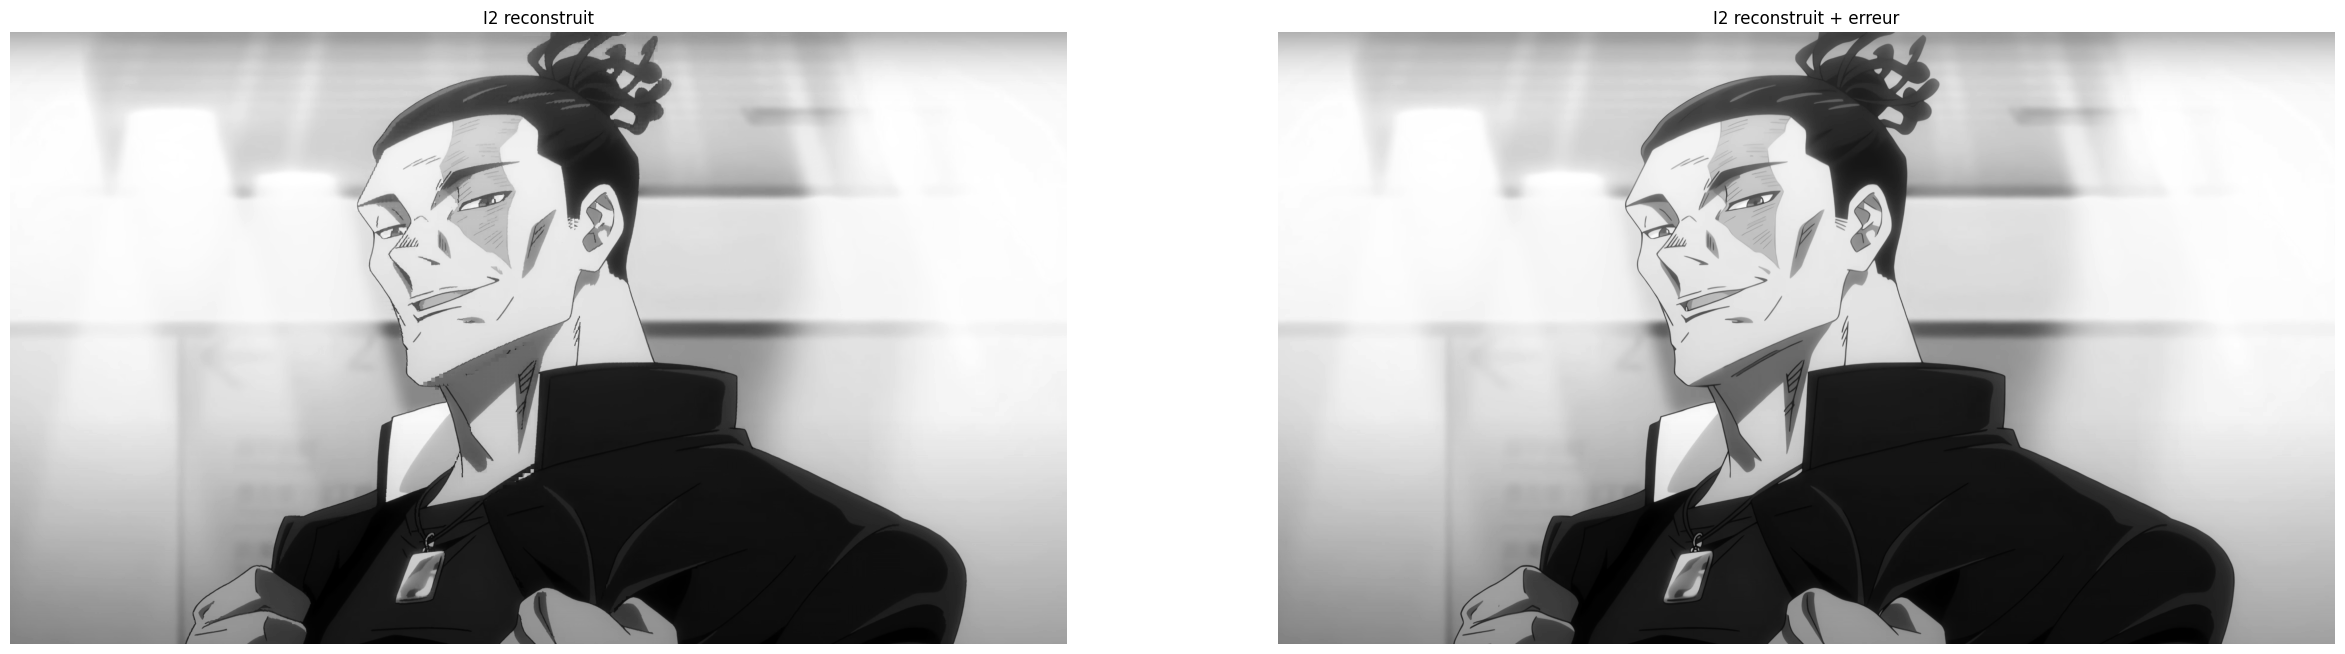

In [21]:
plt.figure(figsize=(30, 12))

plt.subplot(1, 2, 1)
plt.title("I2 reconstruit")
plt.imshow(I2_reconstruit, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("I2 reconstruit + erreur")
plt.imshow(I2_parfait, cmap='gray')
plt.axis('off')

In [23]:
fig4, ax4 = plt.subplots(figsize=(12, 12))
def update_plot4(frame):
    ax4.clear()
    img = I2_reconstruit if frame % 2 == 0 else I2_parfait
    ax4.imshow(img, cmap='gray', interpolation='nearest')
    ax4.set_title('Comparaison entre I2_reconstruit et I2_parfait')
    ax4.set_aspect('equal', adjustable='box')

ani4 = animation.FuncAnimation(fig4, update_plot4, frames=range(10), interval=1000)
video4 = ani4.to_html5_video()
plt.close(fig4)
HTML(video4)

# Utilisation de notre 2ème set d'image

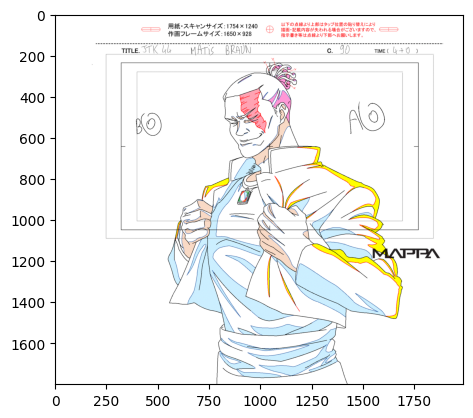

1980
1800


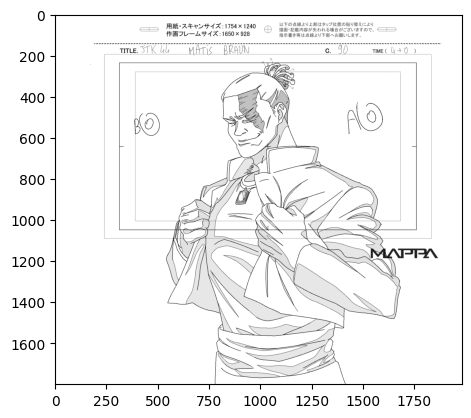

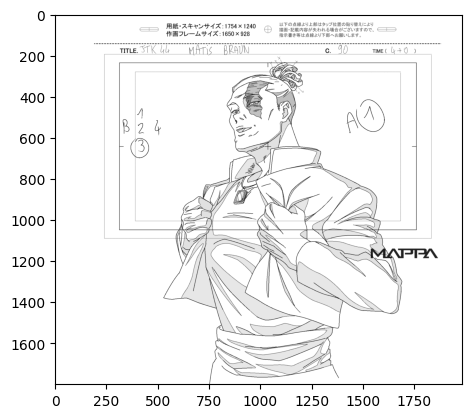

In [25]:
IMG3 = Image.open("/kaggle/input/todogengacv/TodoGenga1.PNG")
IMG4 = Image.open("/kaggle/input/todogengacv/TodoGenga2.PNG")

img3 = np.asarray(IMG3) / 255
img4 = np.asarray(IMG4) / 255

#img1 = img1[:height, :width - 4]
#img2 = img2[:height, :width - 4]

#print(len(img3[0]))
#print(len(img3))

imgplot2 = plt.imshow(img3)
plt.show()

img3_g = np.dot(img3[..., :3], [0.2989, 0.5870, 0.1140])
img4_g = np.dot(img4[..., :3], [0.2989, 0.5870, 0.1140])

height2, width2 = img3_g.shape

img3_g = img3_g[:height2, 8:width2]
img4_g = img4_g[:height2, 8:width2]

print(len(img3_g[0]))
print(len(img3_g))


imgplot2 = plt.imshow(img3_g, cmap= 'gray')
plt.show()
imgplot2 = plt.imshow(img4_g, cmap= 'gray')
plt.show()

In [26]:
fig2, ax2 = plt.subplots(figsize=(12, 12))
def update_plot2(frame):
    ax2.clear()
    img = img3_g if frame % 2 == 0 else img4_g
    ax2.imshow(img, cmap='gray', interpolation='nearest')
    ax2.set_title('Comparaison des 2 images')
    ax2.set_aspect('equal', adjustable='box')

ani2 = animation.FuncAnimation(fig2, update_plot2, frames=range(10), interval=1000)
video2 = ani2.to_html5_video()
plt.close(fig2)
HTML(video2)

In [27]:
block_size2 = 10
search_range2 = 50
vecteur_mouvement2 = estimation_mouvement(img3_g, img4_g, block_size2, search_range2)

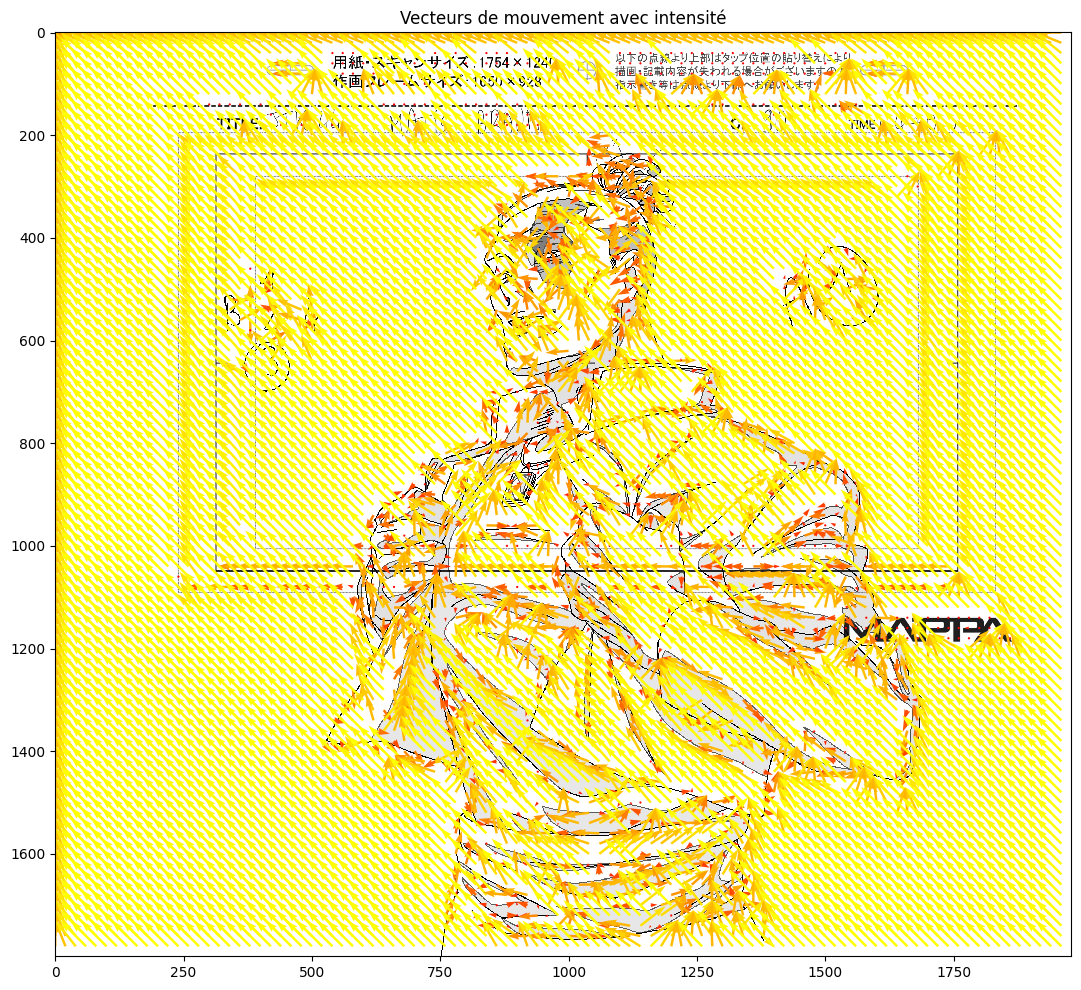

In [28]:
div_fleches2 = 2
div_vecteurs2 = vecteur_mouvement2[::div_fleches2, ::div_fleches2]
div_height2, div_width2, _ = div_vecteurs2.shape
Y2, X2 = np.mgrid[0:div_height2, 0:div_width2] * block_size2 * div_fleches2
U2 = div_vecteurs2[:, :, 0]
V2 = div_vecteurs2[:, :, 1]
intensite_distance2 = np.sqrt(U2**2 + V2**2)

plt.figure(figsize=(30, 12))
plt.imshow(img4_g, cmap='gray', interpolation='nearest')
quiver2 = plt.quiver(X2, Y2, V2, U2, intensite_distance2, angles='xy', scale_units='xy', scale=1, cmap='autumn')

plt.title('Vecteurs de mouvement avec intensité')
plt.show()

In [30]:
I2_reconstruit2 = reconstruction_image(img3_g, vecteur_mouvement2, block_size2)

mse2 = calcul_mse(img4_g, I2_reconstruit2)
print(f"MSE de reconstruction: {mse2}")

erreur2 = img4_g - I2_reconstruit2

MSE de reconstruction: 0.003380949159484603


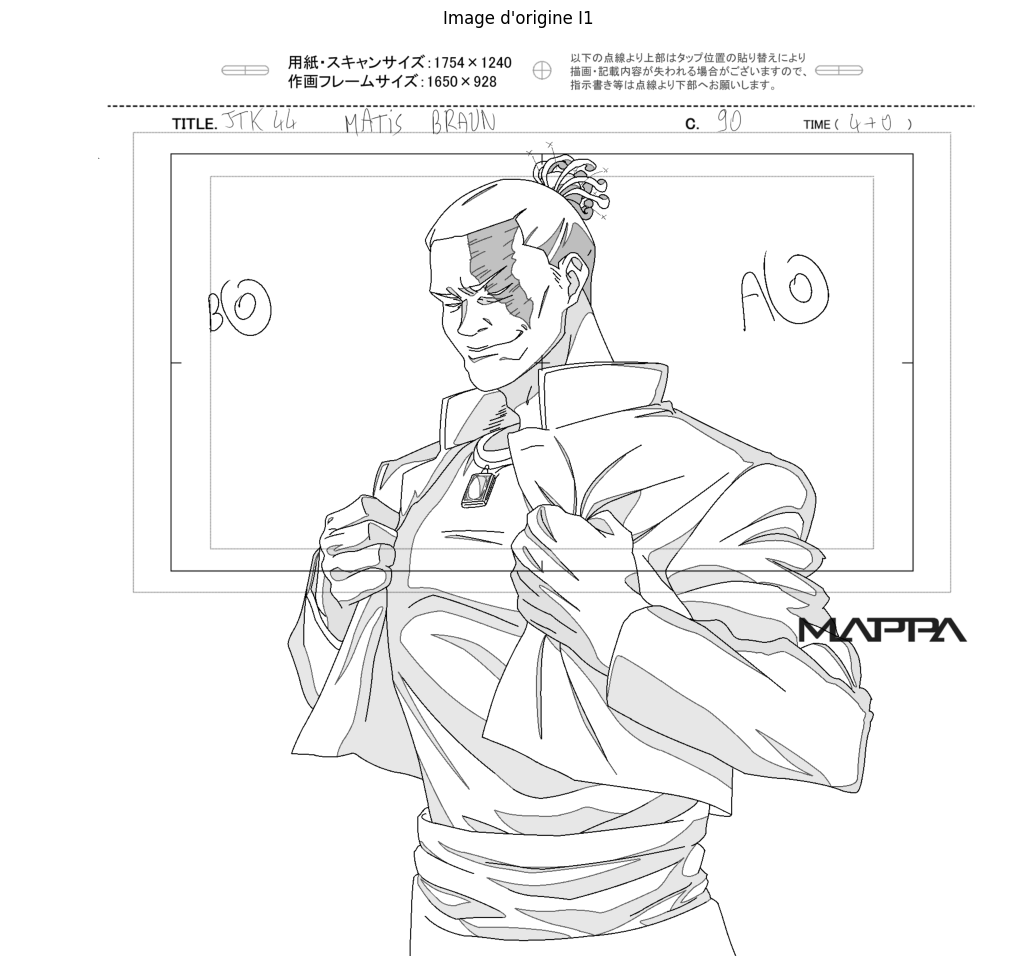

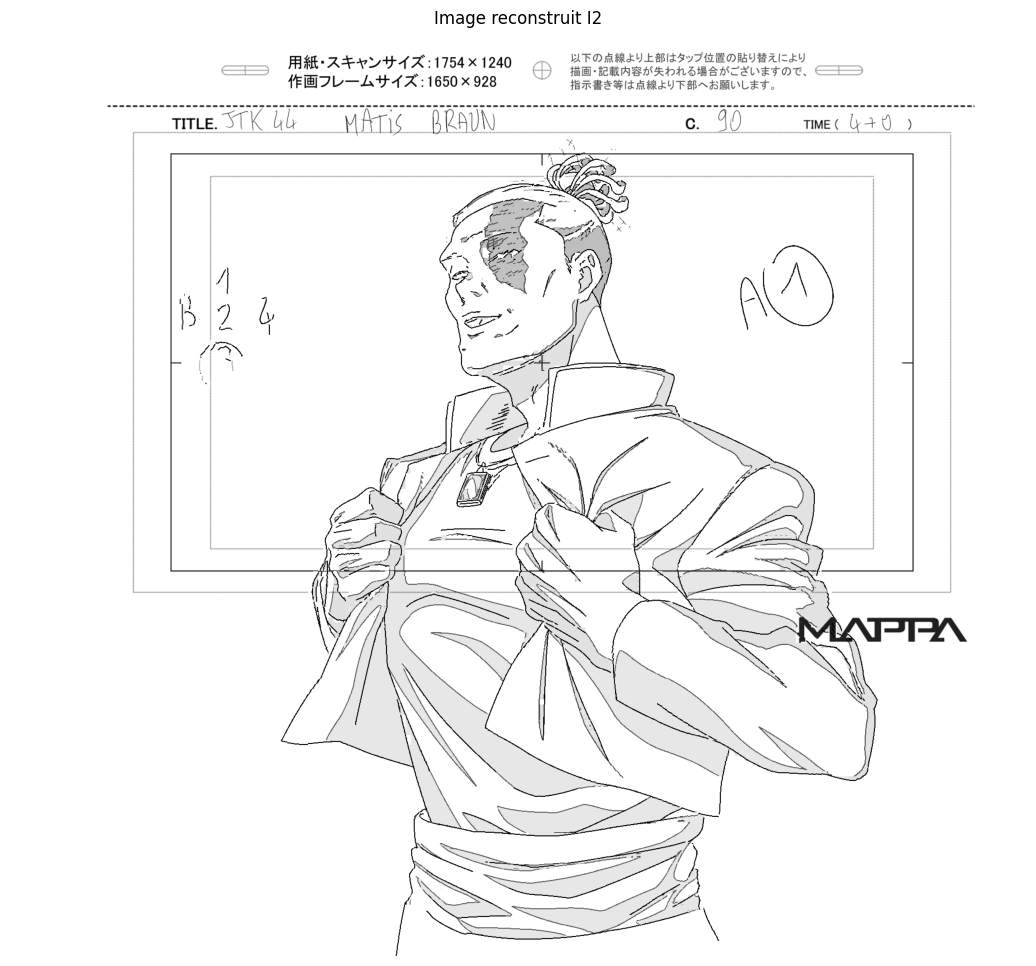

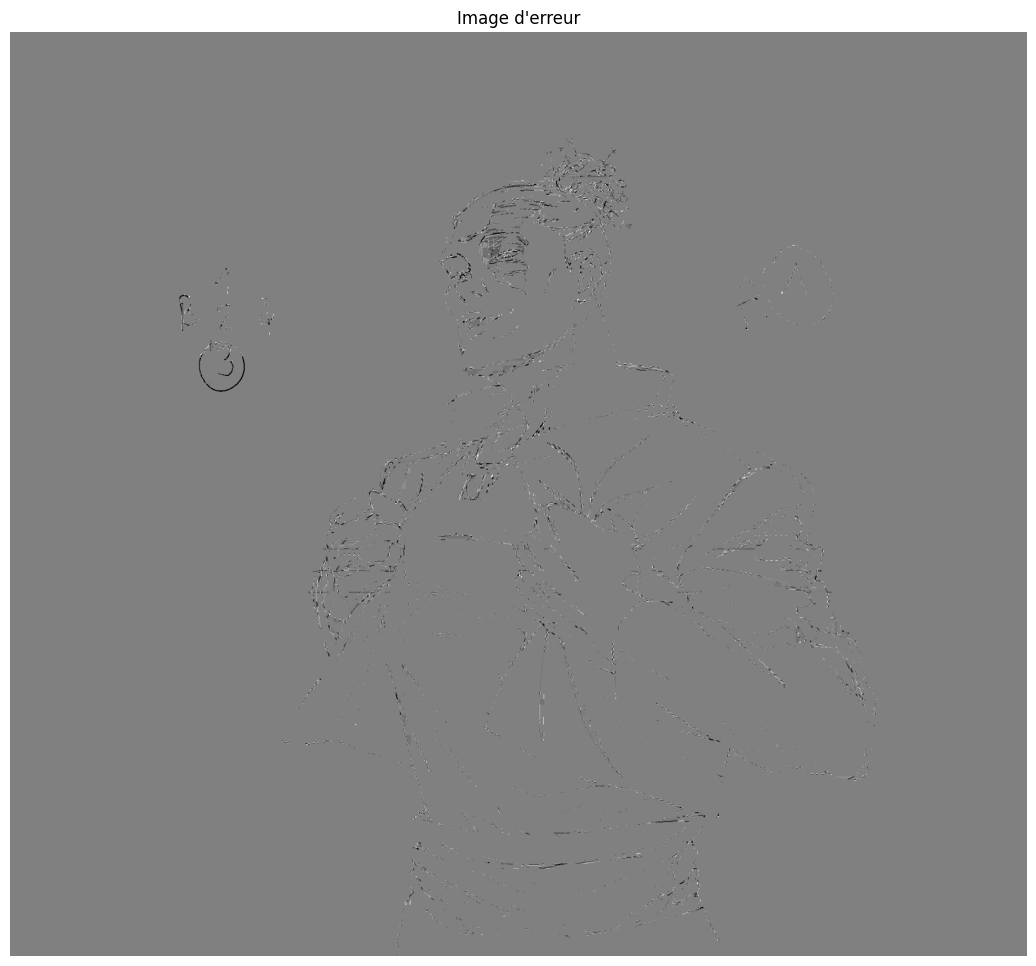

In [31]:
plt.figure(figsize=(30, 12))

plt.title("Image d'origine I1")
plt.imshow(img3_g, cmap= 'gray')
plt.axis('off')

plt.show()

plt.figure(figsize=(30, 12))

plt.title("Image reconstruit I2")
plt.imshow(I2_reconstruit2, cmap='gray')
plt.axis('off')

plt.show()

plt.figure(figsize=(30, 12))

plt.title("Image d'erreur")
plt.imshow(erreur2, cmap='gray')
plt.axis('off')

plt.show()

In [32]:
fig2, ax2 = plt.subplots(figsize=(12, 12))
def update_plot2(frame):
    ax2.clear()
    img = img3_g if frame % 2 == 0 else I2_reconstruit2
    ax2.imshow(img, cmap='gray', interpolation='nearest')
    ax2.set_title('Mouvement entre image 1 et image 2 reconstruit')
    ax2.set_aspect('equal', adjustable='box')

ani2 = animation.FuncAnimation(fig2, update_plot2, frames=range(10), interval=1000)
video2 = ani2.to_html5_video()
plt.close(fig2)
HTML(video2)

In [33]:
I2_parfait2 = I2_reconstruit2 + erreur2

(-0.5, 1979.5, 1799.5, -0.5)

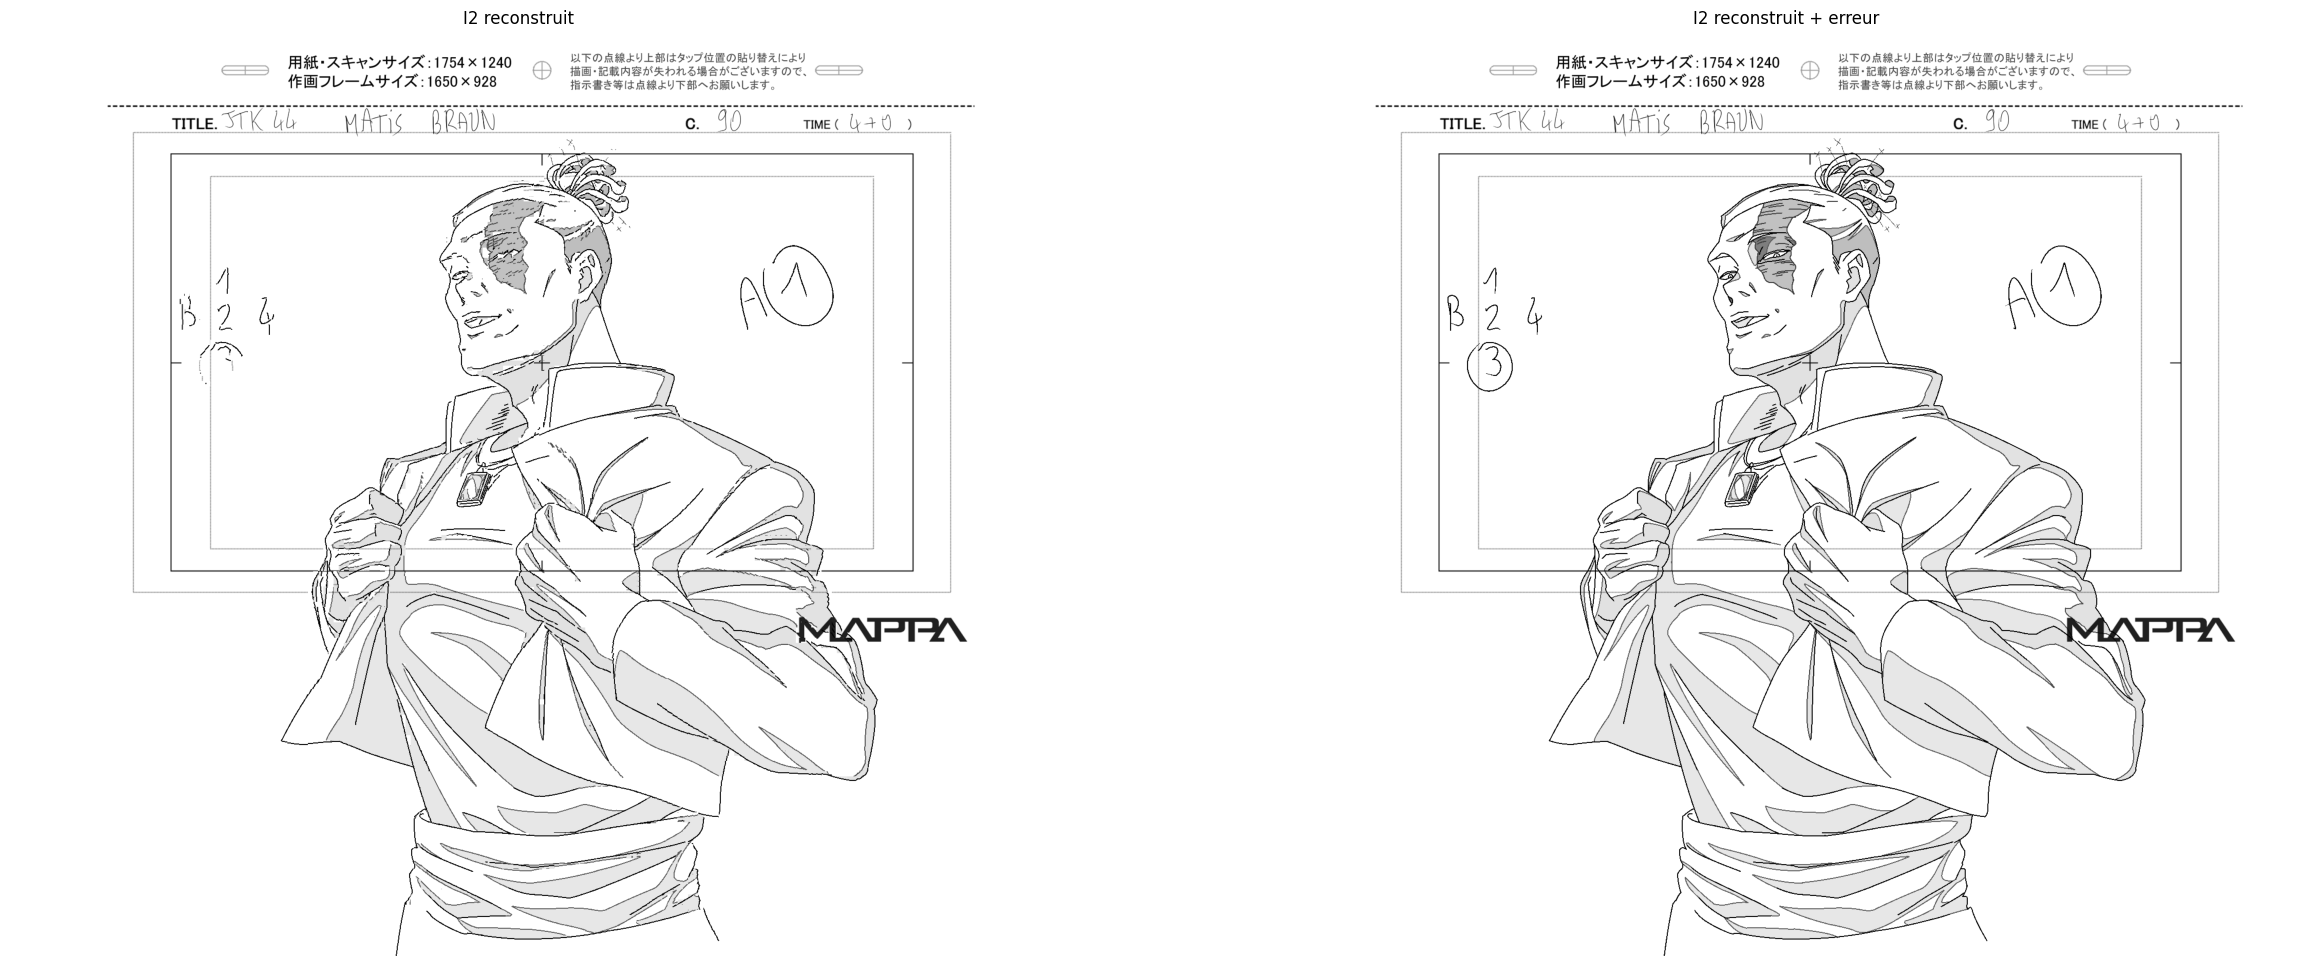

In [34]:
plt.figure(figsize=(30, 12))

plt.subplot(1, 2, 1)
plt.title("I2 reconstruit")
plt.imshow(I2_reconstruit2, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("I2 reconstruit + erreur")
plt.imshow(I2_parfait2, cmap='gray')
plt.axis('off')

In [35]:
fig5, ax5 = plt.subplots(figsize=(12, 12))
def update_plot5(frame):
    ax5.clear()
    img = I2_reconstruit2 if frame % 2 == 0 else I2_parfait2
    ax5.imshow(img, cmap='gray', interpolation='nearest')
    ax5.set_title('Comparaison entre I2_reconstruit et I2_parfait')
    ax5.set_aspect('equal', adjustable='box')

ani5 = animation.FuncAnimation(fig5, update_plot5, frames=range(10), interval=1000)
video5 = ani5.to_html5_video()
plt.close(fig5)
HTML(video5)